# Kaggle competition

## Описание задачи

Описание задачи
Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!
Предлагаем вам принять участие в Мастерской, в рамках которой вы сможете поработать с данными о продажах автомобилей на вторичном рынке. Целью вашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

В этом конкурсе ваша задача - разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.

Данные
train.csv - информация о продажах (440000) автомобилей с аукционов, которые будут использоваться в качестве обучающих данных.
test.csv - информация о продажах (110000) автомобилей с аукционов, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.
sample_submission.csv - файл предсказаний в правильном формате.
vin - идентификатор каждого автомобиля в тестовом наборе.
sellingprice - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости автомобиля.

Описание полей данных
- 'year' - год производства
- 'make' - производитель
- 'model' - модель
- 'trim' - модификация
- 'body' - тип кузова
- 'transmission' - тип КПП
- 'vin' - идентификатор (вин)
- 'state' - штат регистрации
- 'condition' - состояние по шкале (1-5)
- 'odometer' - пробег в милях
- 'color' - цвет кузова
- 'interior' - цвет интерьера
- 'seller' - продавец
- 'sellingprice' - стоимость продажи
- 'saledate' - дата продажи

## Импорт библиотек, подготовка и предобработка данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from dateutil.parser import parse
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, SGDRegressor, HuberRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

In [4]:
train = pd.read_csv('train.csv', low_memory=True)
test = pd.read_csv('test.csv', low_memory=True)

In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057

In [6]:
train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [7]:
test.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [8]:
train['saledate']=train['saledate'].apply(lambda x: pd.to_datetime(parse(x)))
test['saledate']=test['saledate'].apply(lambda x: pd.to_datetime(parse(x)))

In [9]:
#добавляем количество годов пользования
date_format = "%Y-%m-%d %H:%M:%S%z"
train['use_time'] = train['saledate'].apply(lambda x: datetime.strptime(str(x), date_format).year)-train['year']
test['use_time'] = test['saledate'].apply(lambda x: datetime.strptime(str(x), date_format).year)-test['year']

In [10]:
print(train[train['use_time']<0]['use_time'].unique()) #продали машину до того как произвели - мб сразу с завода
# требует пояснения
# -1 есть и в тестовых данных
train[train['use_time']<0].shape

[-1]


(166, 16)

In [11]:
print(test[test['use_time']<0]['use_time'].unique())
test[test['use_time']<0].shape

[-1]


(35, 15)

In [12]:
#год продажи авто - параметр не значимый для обучения модели
print(train['saledate'].apply(lambda x: datetime.strptime(str(x), date_format).year).unique())
print(test['saledate'].apply(lambda x: datetime.strptime(str(x), date_format).year).unique())

[2015 2014]
[2015 2014]


In [13]:
#дубликаты
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [14]:
print(train['vin'].duplicated().sum())
print(test['vin'].duplicated().sum())

0
0


In [15]:
print(train.drop(columns=['vin']).duplicated().sum())
print(test.drop(columns=['vin']).duplicated().sum())

0
0


Дубликатов vin - нет и строк также нет. 

In [16]:
def nul_sum(x):
    n1 = str(x)
    return print(x, ': ',train[n1].isnull().sum(), test[n1].isnull().sum())

In [17]:
#вывод суммы пропусков в каждом ДФ (мне так удобнее смотреть)
print(' feat ', ' train ' , ' test ' )
for i in test.columns:
    nul_sum(i)

 feat   train   test 
year :  0 0
make :  8043 2061
model :  8123 2079
trim :  8337 2114
body :  10393 2594
transmission :  51461 13011
vin :  0 0
state :  0 0
condition :  9405 2379
odometer :  69 19
color :  586 158
interior :  586 158
seller :  0 0
saledate :  0 0
use_time :  0 0


отсутствие пробега - эти данные можно исключить, отсутствующие данные по цвету - можно исключить или добавить категорию - "не указано"

In [18]:
train['make']=train['make'].str.lower()
print(train['make'].nunique()) # есть дубликаты
train['make'].unique()

62


array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai', nan,
       'buick', 'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab',
       'dodge', 'mercedes-benz', 'toyota', 'volkswagen', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'mercedes', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo', 'audi',
       'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche', 'land rover',
       'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker',
       'maserati', 'tesla', 'landrover', 'vw', 'gmc truck', 'rolls-royce',
       'ferrari', 'plymouth', 'lamborghini', 'geo', 'ford truck',
       'aston martin', 'daewoo', 'mercedes-b', 'dodge tk', 'mazda tk',
       'dot', 'airstream'], dtype=object)

In [19]:
test['make']=test['make'].str.lower()
print(test['make'].nunique()) # есть дубликаты
test['make'].unique()

58


array(['cadillac', 'gmc', 'nissan', 'chevrolet', 'volkswagen', 'hyundai',
       'ford', 'infiniti', 'subaru', 'kia', 'bmw', nan, 'mitsubishi',
       'dodge', 'oldsmobile', 'volvo', 'pontiac', 'acura', 'honda',
       'toyota', 'audi', 'jeep', 'lincoln', 'chrysler', 'mercedes-benz',
       'ram', 'scion', 'mercury', 'lexus', 'saturn', 'mazda', 'porsche',
       'mini', 'smart', 'buick', 'hummer', 'jaguar', 'fiat', 'saab',
       'suzuki', 'land rover', 'landrover', 'geo', 'chev truck',
       'bentley', 'isuzu', 'aston martin', 'maserati', 'daewoo', 'vw',
       'tesla', 'mercedes', 'ferrari', 'fisker', 'rolls-royce', 'lotus',
       'plymouth', 'hyundai tk', 'ford tk'], dtype=object)

In [20]:
#уменьшу кол-во категорий в признаке "производитель"
category_mapping = {
    'ford': 'ford',
    'nissan': 'nissan',
    'hummer': 'hummer',
    'lincoln': 'lincoln',
    'pontiac': 'pontiac',
    'hyundai': 'hyundai',
    'buick': 'buick',
    'chevrolet': 'chevrolet',
    'honda': 'honda',
    'acura': 'acura',
    'cadillac': 'cadillac',
    'gmc': 'gmc',
    'saab': 'saab',
    'dodge': 'dodge',
    'mercedes-benz': 'mercedes',
    'toyota': 'toyota',
    'volkswagen': 'volkswagen',
    'bmw': 'bmw',
    'infiniti': 'infiniti',
    'chrysler': 'chrysler',
    'kia': 'kia',
    'jaguar': 'jaguar',
    'subaru': 'subaru',
    'jeep': 'jeep',
    'lexus': 'lexus',
    'mercedes': 'mercedes',
    'scion': 'scion',
    'fiat': 'fiat',
    'suzuki': 'suzuki',
    'mazda': 'mazda',
    'volvo': 'volvo',
    'audi': 'audi',
    'mini': 'mini',
    'isuzu': 'isuzu',
    'mitsubishi': 'mitsubishi',
    'smart': 'smart',
    'porsche': 'porsche',
    'land rover': 'land rover',
    'saturn': 'saturn',
    'ram': 'ram',
    'oldsmobile': 'oldsmobile',
    'mercury': 'mercury',
    'bentley': 'bentley',
    'fisker': 'fisker',
    'maserati': 'maserati',
    'tesla': 'tesla',
    'landrover': 'land rover',
    'vw': 'volkswagen',
    'gmc truck': 'gmc',
    'rolls-royce': 'rolls-royce',
    'ferrari': 'ferrari',
    'plymouth': 'plymouth',
    'lamborghini': 'lamborghini',
    'geo': 'geo',
    'ford truck': 'ford',
    'aston martin': 'aston martin',
    'daewoo': 'daewoo',
    'mercedes-b': 'mercedes',
    'dodge tk': 'dodge',
    'mazda tk': 'mazda',
    'dot': 'dot',
    'airstream': 'airstream'
}
train['make'] = train['make'].replace(category_mapping)
test['make'] = test['make'].replace(category_mapping)

In [21]:
print(train['make'].nunique())
print(test['make'].nunique())

54
55


In [22]:
train['model']=train['model'].str.lower()
print(train['model'].nunique()) # есть дубликаты
test['model']=test['model'].str.lower()
print(test['model'].nunique()) # есть дубликаты

839
746


In [23]:
train['body'].unique() 

array(['suv', 'Sedan', 'sedan', nan, 'SUV', 'wagon', 'Minivan',
       'Extended Cab', 'Regular Cab', 'Coupe', 'SuperCrew', 'Wagon',
       'convertible', 'Crew Cab', 'SuperCab', 'Convertible', 'Hatchback',
       'minivan', 'hatchback', 'G Coupe', 'G Convertible', 'coupe',
       'Access Cab', 'G Sedan', 'regular cab', 'e-series van',
       'supercrew', 'Quad Cab', 'tsx sport wagon', 'Van', 'g sedan',
       'E-Series Van', 'CTS Coupe', 'Koup', 'King Cab', 'extended cab',
       'double cab', 'Elantra Coupe', 'koup', 'access cab', 'Double Cab',
       'crew cab', 'quad cab', 'g coupe', 'CrewMax Cab', 'supercab',
       'g convertible', 'Genesis Coupe', 'van', 'G37 Coupe', 'club cab',
       'Beetle Convertible', 'Mega Cab', 'regular-cab', 'Xtracab',
       'cts coupe', 'genesis coupe', 'Club Cab', 'q60 coupe', 'mega cab',
       'crewmax cab', 'Promaster Cargo Van', 'king cab', 'CTS-V Coupe',
       'TSX Sport Wagon', 'CTS Wagon', 'Cab Plus 4', 'G37 Convertible',
       'Transit Van'

In [24]:
test['body'].unique() 

array(['Sedan', 'Van', 'SUV', 'Crew Cab', 'wagon', 'G Sedan', 'Hatchback',
       'sedan', 'Convertible', 'crew cab', nan, 'van', 'Minivan', 'Wagon',
       'Coupe', 'suv', 'supercrew', 'minivan', 'SuperCrew', 'quad cab',
       'g coupe', 'CrewMax Cab', 'Regular Cab', 'G37 Coupe', 'hatchback',
       'Quad Cab', 'regular cab', 'coupe', 'E-Series Van', 'Extended Cab',
       'supercab', 'e-series van', 'Access Cab', 'G Coupe', 'convertible',
       'Double Cab', 'extended cab', 'SuperCab', 'king cab', 'g sedan',
       'CTS Coupe', 'genesis coupe', 'Beetle Convertible', 'access cab',
       'Promaster Cargo Van', 'crewmax cab', 'G Convertible', 'Mega Cab',
       'koup', 'Elantra Coupe', 'Koup', 'Q60 Convertible',
       'g convertible', 'Q60 Coupe', 'double cab', 'Club Cab', 'King Cab',
       'CTS-V Coupe', 'Xtracab', 'Genesis Coupe', 'tsx sport wagon',
       'club cab', 'mega cab', 'cts coupe', 'elantra coupe',
       'cts-v coupe', 'granturismo convertible', 'Cab Plus',
       'TS

In [25]:
train['body']=train['body'].str.lower()
print(train['body'].nunique()) # есть дубликаты
test['body']=test['body'].str.lower()
print(test['body'].nunique()) # есть дубликаты

45
42


In [26]:
#уменьшу кол-во категорий в признаке "тип кузова"
category_mapping = {
    'suv': 'suv',
    'sedan': 'sedan',
    'wagon': 'wagon',
    'minivan': 'minivan',
    'extended cab': 'truck',
    'regular cab': 'truck',
    'coupe': 'coupe',
    'supercrew': 'truck',
    'convertible': 'convertible',
    'crew cab': 'truck',
    'supercab': 'truck',
    'hatchback': 'hatchback',
    'g coupe': 'coupe',
    'g convertible': 'convertible',
    'access cab': 'truck',
    'g sedan': 'sedan',
    'e-series van': 'van',
    'quad cab': 'truck',
    'tsx sport wagon': 'wagon',
    'van': 'van',
    'cts coupe': 'coupe',
    'koup': 'coupe',
    'king cab': 'truck',
    'double cab': 'truck',
    'elantra coupe': 'coupe',
    'crewmax cab': 'truck',
    'genesis coupe': 'coupe',
    'g37 coupe': 'coupe',
    'club cab': 'truck',
    'beetle convertible': 'convertible',
    'mega cab': 'truck',
    'regular-cab': 'truck',
    'xtracab': 'truck',
    'q60 coupe': 'coupe',
    'promaster cargo van': 'van',
    'cts-v coupe': 'coupe',
    'cts wagon': 'wagon',
    'cab plus 4': 'truck',
    'g37 convertible': 'convertible',
    'transit van': 'van',
    'q60 convertible': 'convertible',
    'cab plus': 'truck',
    'ram van': 'van',
    'granturismo convertible': 'convertible',
    'cts-v wagon': 'wagon'
}
train['body'] = train['body'].replace(category_mapping)
test['body'] = test['body'].replace(category_mapping)

In [27]:
print(test['body'].unique())
print(train['body'].unique())

['sedan' 'van' 'suv' 'truck' 'wagon' 'hatchback' 'convertible' nan
 'minivan' 'coupe']
['suv' 'sedan' nan 'wagon' 'minivan' 'truck' 'coupe' 'convertible'
 'hatchback' 'van']


In [28]:
train['trim']=train['trim'].str.lower()
print(train['trim'].nunique()) # есть дубликаты
test['trim']=test['trim'].str.lower()
print(test['trim'].nunique()) # есть дубликаты

1850
1457


~ примерно 1000 моделей и больше модификаций...

In [29]:
train['year']=train['year'].astype('int')
test['year']=test['year'].astype('int')
train[['state', 'vin']]=train[['state', 'vin']].astype('str')
test[['state', 'vin']]=test[['state', 'vin']].astype('str')

In [30]:
train['state']=train['state'].str.lower()
print(train['state'].nunique())
test['state']=test['state'].str.lower()
print(test['state'].nunique())

38
38


In [31]:
test['state'].unique() 

array(['ca', 'pa', 'oh', 'fl', 'tn', 'nc', 'il', 'ga', 'in', 'mi', 'tx',
       'wi', 'ny', 'pr', 'sc', 'wa', 'mn', 'md', 'co', 'va', 'la', 'nv',
       'mo', 'ut', 'on', 'ma', 'qc', 'ms', 'nj', 'az', 'hi', 'or', 'ab',
       'ne', 'nm', 'ns', 'ok', 'al'], dtype=object)

In [32]:
test['state'].unique() 

array(['ca', 'pa', 'oh', 'fl', 'tn', 'nc', 'il', 'ga', 'in', 'mi', 'tx',
       'wi', 'ny', 'pr', 'sc', 'wa', 'mn', 'md', 'co', 'va', 'la', 'nv',
       'mo', 'ut', 'on', 'ma', 'qc', 'ms', 'nj', 'az', 'hi', 'or', 'ab',
       'ne', 'nm', 'ns', 'ok', 'al'], dtype=object)

In [33]:
train['seller']=train['seller'].str.lower()
print(train['seller'].nunique())
test['seller']=test['seller'].str.lower()
print(test['seller'].nunique())

13025
7623


In [34]:
train['interior']=train['interior'].str.lower()
print(train['interior'].nunique())
test['interior']=test['interior'].str.lower()
print(test['interior'].nunique())

17
17


In [35]:
train['color']=train['color'].str.lower()
print(train['color'].nunique())
test['color']=test['color'].str.lower()
print(test['color'].nunique())

20
20


In [36]:
train['transmission']=train['transmission'].str.lower()
print(train['transmission'].nunique())
test['color']=test['transmission'].str.lower()
print(test['transmission'].nunique())

2
2


In [37]:
#назначу целевой признак, количественные и категориальные признаки 
target = 'sellingprice'
numeric_features = ['year', 'condition', 'odometer', 'use_time']
categorical_features = ['make', 'body', 'state', 'model', 'color', 'interior', 'transmission', 'trim', 'seller']
train_data = train[numeric_features+categorical_features]
test_data = test[numeric_features+categorical_features]

X_train = train_data
y_train = train[target]
X_test = test_data

#для кодирования и нормировки и заполнения пропусков
combined_data = pd.concat([X_train, X_test], ignore_index=True)
train_index = len(X_train)

In [38]:
#пропуски в категориальных данных заполню кат.'Н/у' и модой
combined_data['make'] = combined_data['make'].fillna('Н/у')
combined_data['body'] = combined_data['body'].fillna('Н/у')
combined_data['model'] = combined_data['model'].fillna('Н/у')
combined_data['color'] = combined_data['color'].fillna(combined_data['color'].mode().iloc[0])
combined_data['interior'] = combined_data['interior'].fillna(combined_data['interior'].mode().iloc[0])
combined_data['transmission'] = combined_data['transmission'].fillna(combined_data['transmission'].mode().iloc[0])
combined_data['trim'] = combined_data['trim'].fillna(combined_data['trim'].mode().iloc[0])

In [39]:
#заполняю пропуски количественных данных медианой по группе use_time
combined_data.isnull().sum()
combined_data['odometer'] = combined_data.groupby('use_time')['odometer'].transform(lambda x: x.fillna(x.median()))
combined_data['condition'] = combined_data.groupby(['use_time', 'state'])['condition'].transform(lambda x: x.fillna(x.median()))
combined_data['condition'] = combined_data.groupby(['use_time'])['condition'].transform(lambda x: x.fillna(x.median()))

In [40]:
combined_data.isnull().sum()

year            0
condition       0
odometer        0
use_time        0
make            0
body            0
state           0
model           0
color           0
interior        0
transmission    0
trim            0
seller          0
dtype: int64

Пропуски заполнены. 

### Анализ данных

In [41]:
#разделю датасет на изначальные train и test
X_train = combined_data.iloc[:train_index]
X_test = combined_data.iloc[train_index:]
#датасет для анализа 
data = X_train
data = data.merge(y_train, left_index=True, right_index=True)

In [42]:
#для CatBoost
X_train_CatBoost = X_train.copy()
X_test_CatBoost = X_test.copy()
y_train_CatBoost = y_train.copy()
#для 
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
y_train_lgbm = y_train.copy()

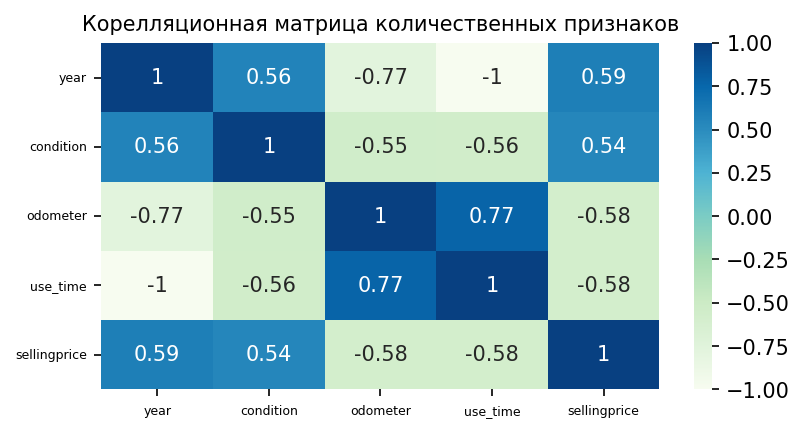

In [43]:
plt.figure(figsize=(6,3), dpi= 150)
sns.heatmap(data.corr().round(2), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='GnBu', center=0, annot=True)

plt.title('Корелляционная матрица количественных признаков', fontsize=10)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

От количественных признаков целевой очень хорошо зависит и хорошо коррелирует (простите за повтор). Пробег сильно зависит от времени использования. Чем дольше владеют, тем хуже состояние - логично. Чем старше машина, тем хуже состояние. Также признаки год и время использования - коллинеарны. Не буду использовать при обучении use_time.

In [44]:
data.describe()

,year,condition,odometer,use_time,sellingprice
count,440236.000000,440236.000000,440236.000000,440236.000000,440236.000000
mean,2010.040101,3.411840,68352.421695,4.862410,13592.209588
std,3.977945,0.948964,53544.099303,3.954387,9751.479098
min,1982.000000,1.000000,1.000000,-1.000000,1.000000
25%,2007.000000,2.700000,28259.000000,2.000000,6900.000000
50%,2012.000000,3.600000,52103.000000,3.000000,12100.000000
75%,2013.000000,4.200000,99283.000000,7.000000,18200.000000
max,2015.000000,5.000000,999999.000000,33.000000,230000.000000


<Axes: xlabel='year', ylabel='sellingprice'>

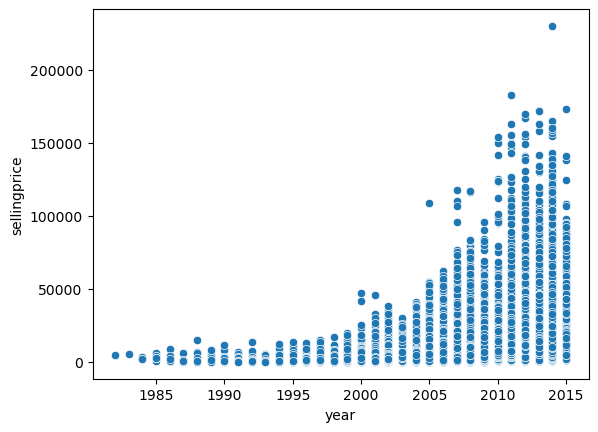

In [45]:
sns.scatterplot(x="year", y="sellingprice", data=data)

In [46]:
#производитель - количество
data['make'].value_counts()

ford            74070
chevrolet       47818
nissan          42866
toyota          31711
dodge           24295
honda           21600
hyundai         17187
bmw             16254
kia             14325
chrysler        13796
mercedes        13408
infiniti        12123
jeep            12107
volkswagen       9901
lexus            9363
gmc              8368
Н/у              8043
mazda            6704
cadillac         5958
acura            4679
audi             4635
lincoln          4541
buick            4023
subaru           4019
pontiac          3596
ram              3592
mitsubishi       3413
volvo            2958
mini             2473
saturn           2247
mercury          1561
land rover       1476
scion            1338
jaguar           1100
porsche          1094
suzuki            846
fiat              672
hummer            597
saab              384
smart             311
oldsmobile        294
isuzu             163
maserati          112
bentley            91
aston martin       23
plymouth  

(array([0., 2., 0., ..., 0., 0., 1.]),
 array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 9.9998e+04, 9.9999e+04,
        1.0000e+05]),
 <BarContainer object of 100000 artists>)

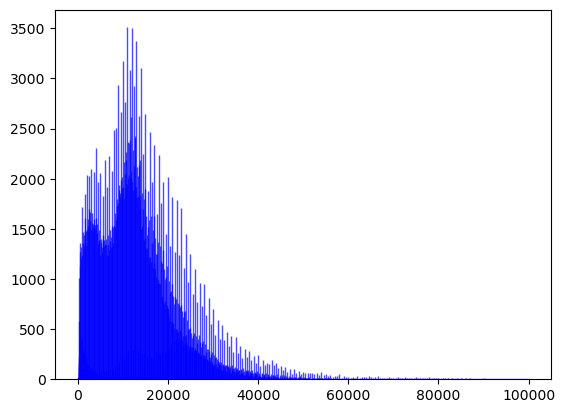

In [47]:
# Построение гистограммы
plt.hist(data['sellingprice'], bins=100000, range=(0, 100000), color='blue', edgecolor='blue', alpha=0.7)

<Axes: xlabel='sellingprice'>

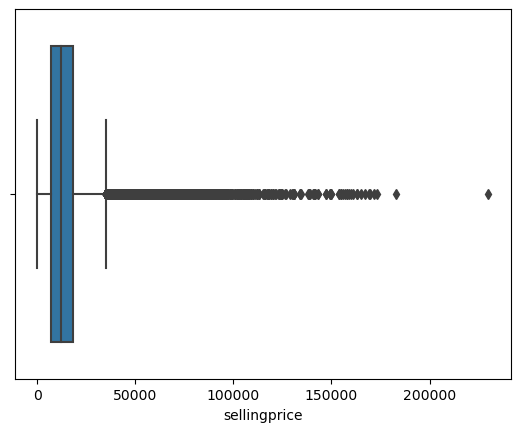

In [48]:
sns.boxplot(x=data['sellingprice'])

Есть маленькие и огромные цены. Для обучения использую ту часть данных, которая лежит в интервале: (q1-1/2*(q3-q1), q3+3*(q3-q1))

In [49]:
q1 = data['sellingprice'].quantile(q=0.25)
q3 = data['sellingprice'].quantile(q=0.75)
z1 = q1-1/2*(q3-q1)
z2 = q3+3*(q3-q1)

In [50]:
data = data[(data['sellingprice']>z1) & (data['sellingprice']<z2)]

In [51]:
data.describe()

,year,condition,odometer,use_time,sellingprice
count,419991.000000,419991.000000,419991.000000,419991.000000,419991.00000
mean,2010.401480,3.466789,64651.844156,4.504444,13842.70412
std,3.539325,0.913848,49103.525871,3.520596,8620.67212
min,1982.000000,1.000000,1.000000,-1.000000,1280.00000
25%,2008.000000,2.800000,27764.000000,2.000000,7700.00000
50%,2012.000000,3.600000,49885.000000,3.000000,12500.00000
75%,2013.000000,4.200000,93865.500000,7.000000,18400.00000
max,2015.000000,5.000000,999999.000000,33.000000,52000.00000


In [52]:
X_train = data.drop(columns='sellingprice', axis=1)
y_train = data['sellingprice']

Количество данных отсеченных по целевому признаку ~ 30к. Категориальные данные model, trim и seller - закодируем следующим образом.: присвоим каждой категории число, равное частоте этой категории в данных. Остальные кат признаки буду кодировать методом ohe.

отношение Н/у к общему количеству ~ 0.001

In [53]:
combined_data = pd.concat([X_train, X_test], ignore_index=True)
train_index = len(X_train)

In [54]:
category_counts = combined_data['seller'].value_counts()
combined_data['seller'] = combined_data['seller'].map(category_counts)
category_counts = combined_data['trim'].value_counts()
combined_data['trim'] = combined_data['trim'].map(category_counts)
category_counts = combined_data['model'].value_counts()
combined_data['model'] = combined_data['model'].map(category_counts)

In [55]:
#нормируем на множество (-1,1) количественные данные
scaler = MinMaxScaler()
combined_data[numeric_features] = scaler.fit_transform(combined_data[numeric_features])
combined_data[['seller', 'trim', 'model']] = scaler.fit_transform(combined_data[['seller', 'trim', 'model']])

In [56]:
combined_data.head(5)

,year,condition,odometer,use_time,make,body,state,model,color,interior,transmission,trim,seller
0,0.878788,0.800,0.111040,0.147059,ford,suv,md,0.307717,black,black,automatic,0.168114,0.760815
1,0.969697,0.625,0.031033,0.058824,ford,sedan,mo,0.677178,black,black,automatic,0.691890,0.140562
2,0.909091,0.300,0.035618,0.117647,nissan,sedan,nj,0.277666,black,black,automatic,0.003502,1.000000
3,0.636364,0.450,0.131300,0.382353,hummer,suv,tx,0.015264,gold,beige,automatic,1.000000,0.008795
4,0.757576,0.250,0.127708,0.264706,ford,sedan,md,0.677178,black,black,automatic,0.168114,0.013777


In [57]:
#кодируем категориальные данные
categorical_features = ['make', 'body', 'state', 'color', 'interior', 'transmission']
encoded_data = pd.get_dummies(combined_data[categorical_features])
combined_data = pd.concat([combined_data, encoded_data], axis=1)

In [58]:
combined_data = combined_data.drop(columns=categorical_features, axis=1)

In [59]:
combined_data = combined_data.drop(columns='use_time', axis=1) #use_time коллинеарен year
combined_data.head(5)

,year,condition,odometer,model,trim,seller,make_acura,make_aston martin,make_audi,make_bentley,...,interior_orange,interior_purple,interior_red,interior_silver,interior_tan,interior_white,interior_yellow,interior_—,transmission_automatic,transmission_manual
0,0.878788,0.800,0.111040,0.307717,0.168114,0.760815,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.969697,0.625,0.031033,0.677178,0.691890,0.140562,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.909091,0.300,0.035618,0.277666,0.003502,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.636364,0.450,0.131300,0.015264,1.000000,0.008795,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.757576,0.250,0.127708,0.677178,0.168114,0.013777,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Данные не удалялись, анализировались только train - перемешивания не было. Разделю датасет combined_data на изначальный train и test

In [60]:
#разделю датасет на изначальные train и test
X_train = combined_data.iloc[:train_index]
X_test = combined_data.iloc[train_index:]
#y_train - остался без изменений

In [61]:
y_train

0         12500
1         14500
2          9100
3         13300
4          1300
          ...  
440231    16000
440232    24250
440233    16750
440234    33000
440235    14500
Name: sellingprice, Length: 419991, dtype: int64

In [62]:
print(X_train.shape[0])
print(y_train.shape[0])

419991
419991


### MAPE для модели константы 

In [63]:
#модель, которая предсказывает все значения средней ценой.
mean_value = y_train.median()

series = pd.Series([mean_value] * (y_train.shape[0]))
mape_base = mape(y_train, series)
test_base = pd.Series([mean_value] * test['vin'].shape[0])
base_res = pd.concat([test['vin'], test_base], axis=1)
base_res.columns = ['vin', 'sellingprice']
base_res.to_csv('avg_res.csv', index=False) # запись в файл

In [64]:
mape_base

0.8801665047058332

/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


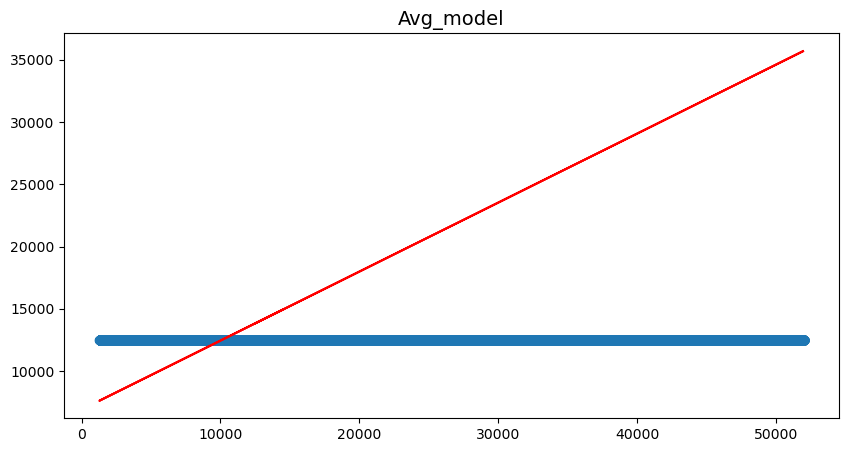

In [65]:
plt.figure(figsize=(10,5))
plt.title('Avg_model', fontsize=14)
plt.scatter(y=[mean_value] * y_train.shape[0], x=y_train)
m, b = np.polyfit([mean_value] * (y_train.shape[0]), y_train, 1) # 
plt.plot(y_train, m*y_train+b, 'r-')

Сделаю таблицу с результатами на train и val

In [66]:
total = []
tab_total = pd.DataFrame(data=total, columns = ['Model', 'train_mape', 'val_mape'])
tab_total

,Model,train_mape,val_mape


In [67]:
res = ['const', 0.88, '']
tab_total.loc[len(tab_total.index)] = res

In [68]:
tab_total

,Model,train_mape,val_mape
0,const,0.88,


## LinearRegression

In [69]:
scoring = make_scorer(mape) #критерий оценки модели
cv_par = 5 #параметр разбития выборки для кросс-валидации
rs=1
#X_train, y_train - для обучения
#X_val, y_val - данные для оценки модели и выбора лучшей модели
#X_test - тестовые данные
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=rs)

In [86]:
start = time.time()
pipeline = Pipeline([('regressor', LinearRegression())])
param_grid = {'regressor__n_jobs': [1]}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=cv_par)
grid_search.fit(X_train, y_train)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print("MAPE: ", grid_search.best_score_)

Время обучения и поиска оптимальных параметров:  0.19  минут
Best Parameters:  {'regressor__n_jobs': 1}
MAPE:  0.3804180148936961


In [87]:
y_pred = grid_search.predict(X_val)
print("MAPE на валидационной выборке: ", mape(grid_search.predict(X_val), y_val))

MAPE на валидационной выборке:  96507238161720.58


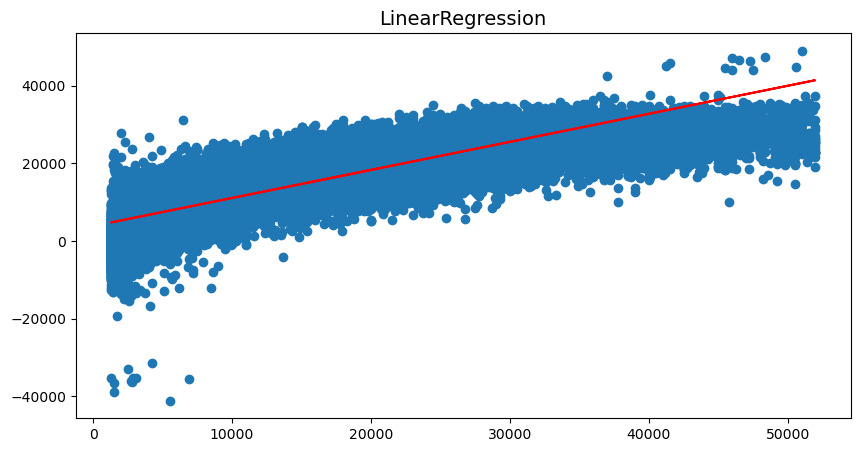

In [88]:
plt.figure(figsize=(10,5))
plt.title('LinearRegression', fontsize=14)
plt.scatter(x=y_val, y=y_pred)
m, b = np.polyfit(y_val, y_pred, 1)
plt.plot(y_val, m*y_val+b, 'r')

In [89]:
y_test = pd.Series(grid_search.predict(X_test))
LR_res = pd.concat([test['vin'], y_test], axis=1)
LR_res.columns = ['vin', 'sellingprice']
LR_res.to_csv('LR_res.csv', index=False)

In [70]:
res = ['LinearRegression', 0.39, '~10^10']
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10


## DecisionTreeRegressor

In [67]:
start = time.time()
pipeline = Pipeline([
    ('regressor', DecisionTreeRegressor())])
param_grid = {'regressor__max_depth': range(1, 30, 2),
             'regressor__random_state': [rs]}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=cv_par)
grid_search.fit(X_train, y_train)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

Время обучения и поиска оптимальных параметров:  2.81  минут
Best Parameters:  {'regressor__max_depth': 1, 'regressor__random_state': 1}
MAPE: 0.62%


In [68]:
y_pred = grid_search.predict(X_val)
sc_mape=mape(grid_search.predict(X_val), y_val)
print(f"MAPE на валидационной выборке: {sc_mape:.2f}%")

MAPE на валидационной выборке: 0.43%


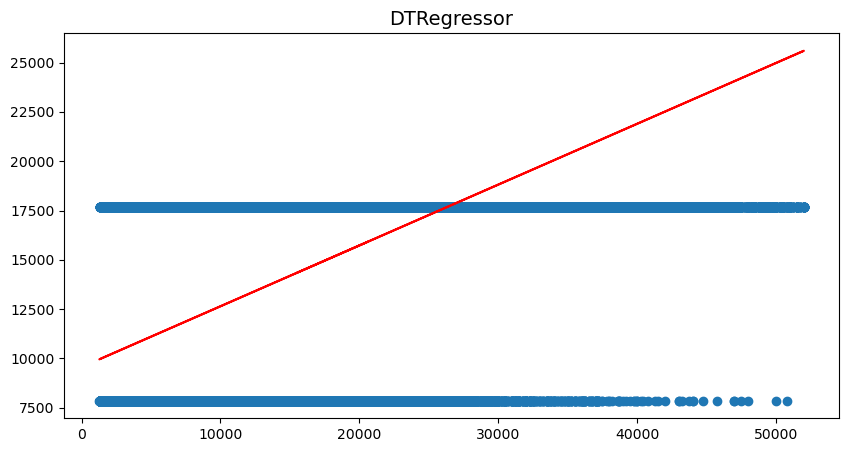

In [69]:
plt.figure(figsize=(10, 5))
plt.title('DTRegressor', fontsize=14)
plt.scatter(x=y_val, y=y_pred)
m, b = np.polyfit(y_val, y_pred, 1)
plt.plot(y_val, m*y_val+b, 'r')

модель переобучена - предсказывает цену выбирая из 2х значений.

In [70]:
y_test = pd.Series(grid_search.predict(X_test))
DTR_res = pd.concat([test['vin'], y_test], axis=1)
DTR_res.columns = ['vin', 'sellingprice']
DTR_res.to_csv('DTR_res.csv', index=False)

In [71]:
res = ['DecisionTreeRegressor', 0.62, 0.43]
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43


## MLPRegressor

In [71]:
import warnings
warnings.simplefilter(action='ignore')

In [72]:
start = time.time()
pipeline = Pipeline([
    ('regressor', MLPRegressor())
])
param_grid = {'regressor__hidden_layer_sizes': [(50,), (150,)],
              'regressor__alpha': [0.01, 0.005],
             'regressor__random_state':[rs], 
              'regressor__max_iter':range(1, 10, 3)}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

Время обучения и поиска оптимальных параметров:  6.31  минут
Best Parameters:  {'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (50,), 'regressor__max_iter': 1, 'regressor__random_state': 1}
MAPE: 0.88%


In [73]:
y_pred = grid_search.predict(X_val)
sc_mape=mape(grid_search.predict(X_val), y_val)
print(f"MAPE на валидационной выборке: {sc_mape:.2f}%")

MAPE на валидационной выборке: 8.10%


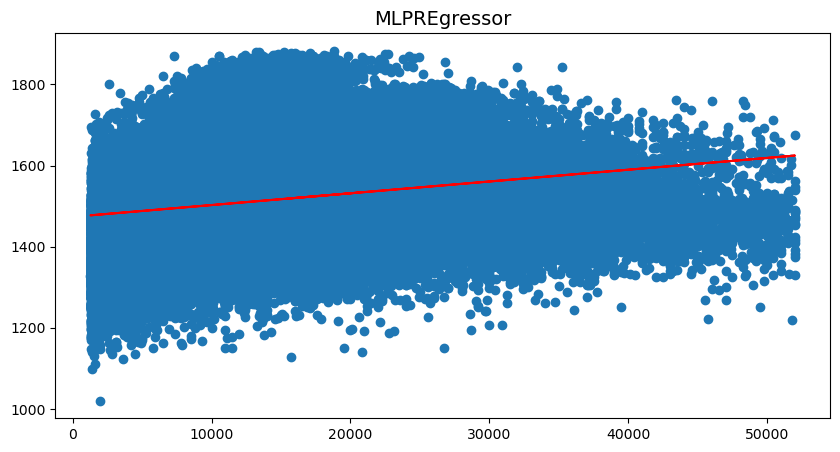

In [74]:
plt.figure(figsize=(10, 5))
plt.title('MLPREgressor', fontsize=14)
plt.scatter(x=y_val, y=y_pred)
m, b = np.polyfit(y_val, y_pred, 1)
plt.plot(y_val, m*y_val+b, 'r')

Отклонение от прямой значительно выше, чем у DTRegressor.

In [75]:
y_test = pd.Series(grid_search.predict(X_test))
MLPR_res = pd.concat([test['vin'], y_test], axis=1)
MLPR_res.columns = ['vin', 'sellingprice']
MLPR_res.to_csv('MLPR_res.csv', index=False)

In [72]:
res = ['MLPRegressor', 0.88, 8.1]
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43
3,MLPRegressor,0.88,8.1


## RandomForestRegressor

In [115]:
start = time.time()
pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])
param_grid = {'regressor__n_estimators': [75, 100, 200],
              'regressor__max_features': [1000],
              'regressor__max_depth': [20, 25],
              'regressor__random_state':[rs], 
              'regressor__n_jobs':[-1]
             }
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

Время обучения и поиска оптимальных параметров:  58.2  минут
Best Parameters:  {'regressor__max_depth': 20, 'regressor__max_features': 1000, 'regressor__n_estimators': 75, 'regressor__n_jobs': -1, 'regressor__random_state': 1}
MAPE: 0.16%


In [116]:
y_pred = grid_search.predict(X_val)
sc_mape=mape(grid_search.predict(X_val), y_val)
print(f"MAPE на валидационной выборке: {sc_mape:.2f}%")

MAPE на валидационной выборке: 0.14%


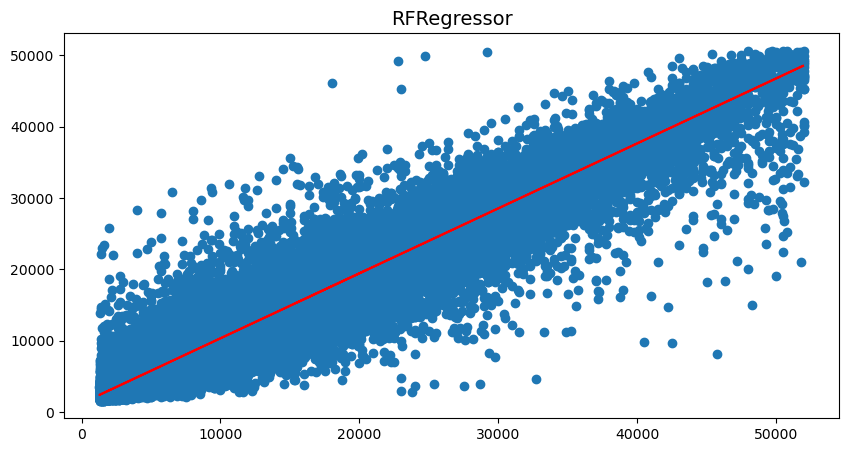

In [117]:
plt.figure(figsize=(10, 5))
plt.title('RFRegressor', fontsize=14)
plt.scatter(x=y_val, y=y_pred)
m, b = np.polyfit(y_val, y_pred, 1)
plt.plot(y_val, m*y_val+b, 'r');

In [118]:
y_test = pd.Series(grid_search.predict(X_test))
RFR_res = pd.concat([test['vin'], y_test], axis=1)
RFR_res.columns = ['vin', 'sellingprice']
RFR_res.to_csv('RFR_res.csv', index=False)

In [73]:
res = ['RandomForest', 0.16, 0.14]
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43
3,MLPRegressor,0.88,8.1
4,RandomForest,0.16,0.14


## GradientBoostingRegressor

In [123]:
start = time.time()
pipeline = Pipeline([
    ('regressor', GradientBoostingRegressor())
])
param_grid = {'regressor__learning_rate': [0.1],
              'regressor__n_estimators': [200],
              'regressor__random_state':[rs], 
              'regressor__loss': ["absolute_error"]
             }
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

Время обучения и поиска оптимальных параметров:  9.44  минут
Best Parameters:  {'regressor__learning_rate': 0.1, 'regressor__loss': 'absolute_error', 'regressor__n_estimators': 200, 'regressor__random_state': 1}
MAPE: 0.23%


In [124]:
y_pred = grid_search.predict(X_val)
sc_mape=mape(grid_search.predict(X_val), y_val)
print(f"MAPE на валидационной выборке: {sc_mape:.2f}%")

MAPE на валидационной выборке: 0.23%


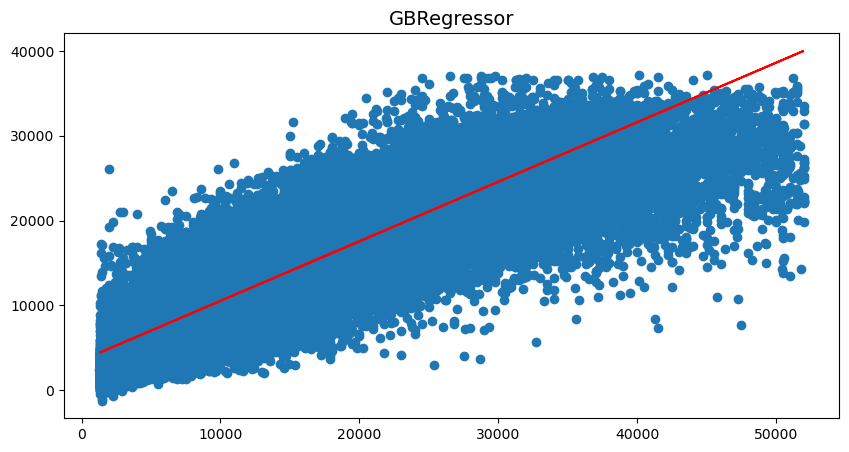

In [125]:
plt.figure(figsize=(10, 5))
plt.title('GBRegressor', fontsize=14)
plt.scatter(x=y_val, y=y_pred)
m, b = np.polyfit(y_val, y_pred, 1)
plt.plot(y_val, m*y_val+b, 'r')

In [126]:
y_test = pd.Series(grid_search.predict(X_test))
GBR_res = pd.concat([test['vin'], y_test], axis=1)
GBR_res.columns = ['vin', 'sellingprice']
GBR_res.to_csv('GBR_res.csv', index=False)

In [74]:
res = ['GradientBoostingRegressor', 0.23, 0.23]
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43
3,MLPRegressor,0.88,8.1
4,RandomForest,0.16,0.14
5,GradientBoostingRegressor,0.23,0.23


## Light GBM Regressor

In [204]:
start = time.time()
pipeline = Pipeline([
    ('regressor', LGBMRegressor())
])
param_grid = {'regressor__learning_rate': [0.1, 0.05],
              'regressor__n_estimators': [100, 250],
              'regressor__random_state':[rs], 
              'regressor__num_leaves':[120, 180]
             }
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

Время обучения и поиска оптимальных параметров:  2.03  минут
Best Parameters:  {'regressor__learning_rate': 0.05, 'regressor__n_estimators': 100, 'regressor__num_leaves': 120, 'regressor__random_state': 1}
MAPE: 0.18%


In [205]:
y_pred = grid_search.predict(X_val)
sc_mape=mape(grid_search.predict(X_val), y_val)
print(f"MAPE на валидационной выборке: {sc_mape:.2f}%")

MAPE на валидационной выборке: 0.15%


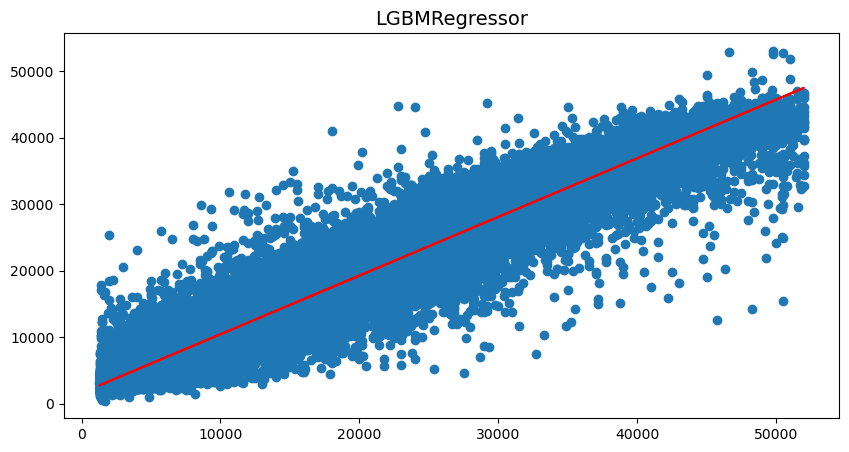

In [206]:
plt.figure(figsize=(10, 5))
plt.title('LGBMRegressor', fontsize=14)
plt.scatter(x=y_val, y=y_pred)
m, b = np.polyfit(y_val, y_pred, 1)
plt.plot(y_val, m*y_val+b, 'r')

In [207]:
y_test = pd.Series(grid_search.predict(X_test))
LGBMR_res = pd.concat([test['vin'], y_test], axis=1)
LGBMR_res.columns = ['vin', 'sellingprice']
LGBMR_res.to_csv('LGBMR_res.csv', index=False)

In [75]:
res = ['Light GBM Regressor', 0.18, 0.15]
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43
3,MLPRegressor,0.88,8.1
4,RandomForest,0.16,0.14
5,GradientBoostingRegressor,0.23,0.23
6,Light GBM Regressor,0.18,0.15


## Light GBM Regressor (catigoricals)

Light GBM Regressor - может кодировать категориальные признаки, поэтому вернусь к данным до кодировки категориальных признаков и разобью их на train и valid - выборки. Требуется изменение категориальных типов столбцов на тип «категория» необработанных данных.

In [63]:
for col in X_train_lgbm.columns:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')

In [64]:
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_train_lgbm, y_train_lgbm, train_size=0.7, random_state=rs)

In [65]:
start = time.time()
pipeline = Pipeline([
    ('regressor', LGBMRegressor())
])
param_grid = {'regressor__learning_rate': [0.1, 0.05],
              'regressor__n_estimators': [50, 100],
              'regressor__random_state':[rs], 
              'regressor__num_leaves':[70, 120]
             }
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train_cat, y_train_cat)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

Время обучения и поиска оптимальных параметров:  1.41  минут
Best Parameters:  {'regressor__learning_rate': 0.05, 'regressor__n_estimators': 50, 'regressor__num_leaves': 70, 'regressor__random_state': 1}
MAPE: 0.38%


In [66]:
y_pred_cat = grid_search.predict(X_val_cat)
sc_mape=mape(grid_search.predict(X_val_cat), y_val_cat)
print(f"MAPE на валидационной выборке: {sc_mape:.2f}%")

MAPE на валидационной выборке: 0.18%


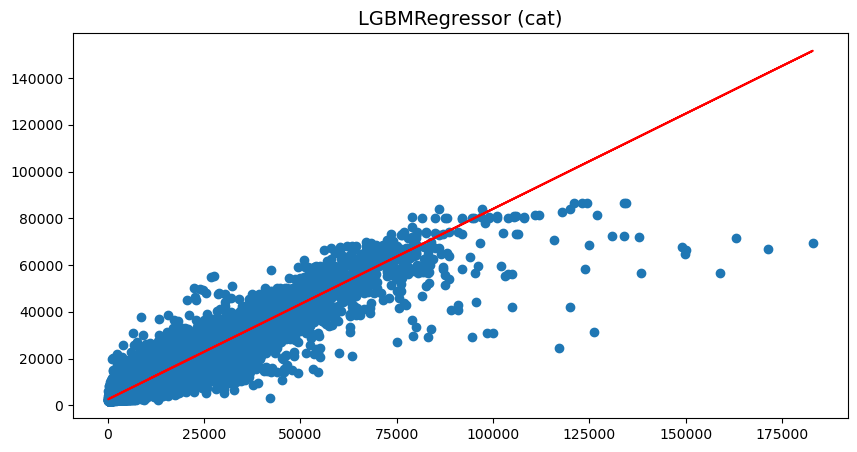

In [67]:
plt.figure(figsize=(10, 5))
plt.title('LGBMRegressor (сat)', fontsize=14)
plt.scatter(x=y_val_cat, y=y_pred_cat)
m, b = np.polyfit(y_val_cat, y_pred_cat, 1)
plt.plot(y_val_cat, m*y_val_cat+b, 'r')

In [68]:
y_test = pd.Series(grid_search.predict(X_test_lgbm))
LGBMR_cat_res = pd.concat([test['vin'], y_test], axis=1)
LGBMR_cat_res.columns = ['vin', 'sellingprice']
LGBMR_cat_res.to_csv('LGBMR_res_cat.csv', index=False)

In [76]:
res = ['Light GBM Regressor (catigoricals)', 0.38, 0.18]
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43
3,MLPRegressor,0.88,8.1
4,RandomForest,0.16,0.14
5,GradientBoostingRegressor,0.23,0.23
6,Light GBM Regressor,0.18,0.15
7,Light GBM Regressor (catigoricals),0.38,0.18


## XGBoost Regressor

In [131]:
start = time.time()
pipeline = Pipeline([
    ('regressor', XGBRegressor())
])
param_grid = {'regressor__learning_rate': [0.1],
              'regressor__n_estimators': [100, 250],
              'regressor__random_state':[rs]
              'regressor__subsample':[0.1, 0.05]
             }
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train, y_train)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

Время обучения и поиска оптимальных параметров:  6.35  минут
Best Parameters:  {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 100, 'regressor__random_state': 1}
MAPE: 0.21%


In [132]:
y_pred = grid_search.predict(X_val)
sc_mape=mape(grid_search.predict(X_val), y_val)
print(f"MAPE на валидационной выборке: {sc_mape:.2f}%")

MAPE на валидационной выборке: 0.18%


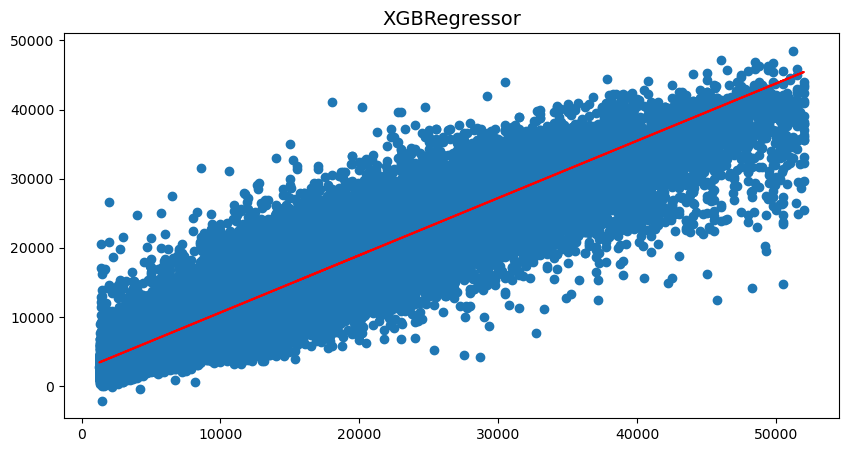

In [133]:
plt.figure(figsize=(10, 5))
plt.title('XGBRegressor', fontsize=14)
plt.scatter(x=y_val, y=y_pred)
m, b = np.polyfit(y_val, y_pred, 1)
plt.plot(y_val, m*y_val+b, 'r')

In [134]:
y_test = pd.Series(grid_search.predict(X_test))
XGBR_res = pd.concat([test['vin'], y_test], axis=1)
XGBR_res.columns = ['vin', 'sellingprice']
XGBR_res.to_csv('XGBR_res.csv', index=False)

In [77]:
res = ['XGBoost Regressor', 0.21, 0.18]
tab_total.loc[len(tab_total.index)] = res
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43
3,MLPRegressor,0.88,8.1
4,RandomForest,0.16,0.14
5,GradientBoostingRegressor,0.23,0.23
6,Light GBM Regressor,0.18,0.15
7,Light GBM Regressor (catigoricals),0.38,0.18
8,XGBoost Regressor,0.21,0.18


## CatBoostRegressor

CatBoost - может кодировать категориальные признаки. Данные для обучения и теста: X_train_CatBoost, X_test_CatBoost, y_train_CatBoost.

In [62]:
X_train_CatBoost.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   condition     440236 non-null  float64
 2   odometer      440236 non-null  float64
 3   use_time      440236 non-null  int64  
 4   make          440236 non-null  object 
 5   body          440236 non-null  object 
 6   state         440236 non-null  object 
 7   model         440236 non-null  object 
 8   color         440236 non-null  object 
 9   interior      440236 non-null  object 
 10  transmission  440236 non-null  object 
 11  trim          440236 non-null  object 
 12  seller        440236 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 43.7+ MB


In [63]:
X_train_CatBoost.isnull().sum()

year            0
condition       0
odometer        0
use_time        0
make            0
body            0
state           0
model           0
color           0
interior        0
transmission    0
trim            0
seller          0
dtype: int64

In [68]:
cat_f=categorical_features

In [72]:
cat_f_ind = np.where(np.in1d(X_train_CatBoost.columns, cat_f))[0].astype('int')
cat_f_ind

array([ 4,  5,  6,  8,  9, 10])

In [73]:
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_train_CatBoost, y_train_CatBoost, train_size=0.7, random_state=rs)

In [74]:
start = time.time()
pipeline = Pipeline([
    ('regressor', CatBoostRegressor())
])
param_grid = {'regressor__learning_rate': [0.1],
              'regressor__iterations': [100],
              'regressor__random_state':[rs], 
              'regressor__rsm': [0.7],
              'regressor__depth': [15],
              'regressor__logging_level': ['Silent'],
              'regressor__cat_features': [cat_f_ind]
             }
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train_cat, y_train_cat)
end = time.time()
print("Время обучения и поиска оптимальных параметров: ", round((end-start)/60, 2), " минут")
# Вывод наилучших параметров и значения MAPE
print("Best Parameters: ", grid_search.best_params_)
print(f"MAPE: {grid_search.best_score_:.2f}%")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2288, in _catboost.get_float_feature
  File "_catboost.pyx", line 1141, in _catboost._FloatOrNan
  File "_catboost.pyx", line 951, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'expedition'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 5734, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 2341, in _fit
    train_params = self._prepare_train_params(
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 2222, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 1438, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 792, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 1419, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3956, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4006, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3822, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2788, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2329, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2290, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=7]="expedition": Cannot convert 'b'expedition'' to float

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2288, in _catboost.get_float_feature
  File "_catboost.pyx", line 1141, in _catboost._FloatOrNan
  File "_catboost.pyx", line 951, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'f-250 super duty'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 5734, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 2341, in _fit
    train_params = self._prepare_train_params(
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 2222, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 1438, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 792, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "/Users/georgiismirnov/anaconda3/lib/python3.10/site-packages/catboost/core.py", line 1419, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3956, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4006, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3822, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2788, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2329, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2290, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=7]="f-250 super duty": Cannot convert 'b'f-250 super duty'' to float


CatBoost failed пока не понял в чем ошибка....

## Результаты

In [78]:
tab_total

,Model,train_mape,val_mape
0,const,0.88,
1,LinearRegression,0.39,~10^10
2,DecisionTreeRegressor,0.62,0.43
3,MLPRegressor,0.88,8.1
4,RandomForest,0.16,0.14
5,GradientBoostingRegressor,0.23,0.23
6,Light GBM Regressor,0.18,0.15
7,Light GBM Regressor (catigoricals),0.38,0.18
8,XGBoost Regressor,0.21,0.18


Для подбора оптимальных гиперпараметров модели параметров наилучшим образом подходят модели обученные методами RandomForest, GradientBoostingRegressor, Light GBM Regressor, XGBoost Regressor. За неимением на данный момент достаточного времени и ресурсов для подбора оптимальных параметров, предварительно обученные модели тестировались на тестовой выборке. 

На тестовых данных (Kaggle) наилучшей моделью (с выбранными гиперпараметрами) показала себя модель обченная методом Light GBM Regressor, обученная на данных, которые кодировались и нормировались "вручную" методами OHE и MinMaxScaler() - MAPE = 19.58 (19.41) с паратметрами {'regressor__learning_rate': 0.05, 'regressor__n_estimators': 100, 'regressor__num_leaves': 120, 'regressor__random_state': 1}.

In [79]:
lgbmr = LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=1, num_leaves=120)
lgbmr.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05, num_leaves=120, random_state=1)

In [85]:
importances=lgbmr.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names=lgbmr.feature_name_
print("Feature importances:")
for f, idx in enumerate(indices):
    i+=1
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'model' (2863.0000)
 2. feature 'trim ' (1704.0000)
 3. feature 'year ' (818.0000)
 4. feature 'odometer' (519.0000)
 5. feature 'body_truck' (383.0000)
 6. feature 'make_bmw' (298.0000)
 7. feature 'make_mercedes' (276.0000)
 8. feature 'condition' (274.0000)
 9. feature 'make_lexus' (249.0000)
10. feature 'body_suv' (231.0000)
11. feature 'make_chevrolet' (210.0000)
12. feature 'make_infiniti' (192.0000)
13. feature 'make_porsche' (169.0000)
14. feature 'make_nissan' (164.0000)
15. feature 'seller' (157.0000)
16. feature 'make_ford' (146.0000)
17. feature 'make_audi' (145.0000)
18. feature 'make_cadillac' (143.0000)
19. feature 'make_jeep' (142.0000)
20. feature 'make_toyota' (137.0000)
21. feature 'body_sedan' (133.0000)
22. feature 'make_land_rover' (125.0000)
23. feature 'body_hatchback' (122.0000)
24. feature 'interior_gray' (117.0000)
25. feature 'make_kia' (111.0000)
26. feature 'make_acura' (105.0000)
27. feature 'make_jaguar' (95.0000)
28. fea

In [ ]:
#Получим 10 наиболее важных признаки для лучшей модели на тестовых данных.

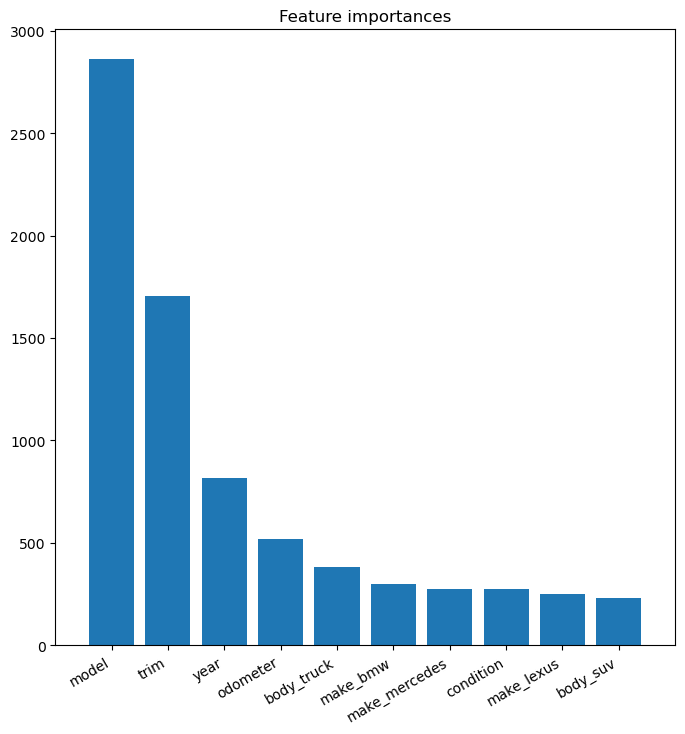

In [97]:
d_first = 10
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=30, ha='right')
plt.xlim([-1, d_first]);

Из полученных данных видно, что наиболее важные признаки это - модель, модификация, год выпуска, пробег и тип кузова.

## Выводы

    1. Проведен анализ данных для задачи регрессии - прогнозирование цены автомобиля на вторичном рынке.
    2. Заполнены пропуски в данных и исключены выбросы. Пропуски заполнялись следующим образом. Отсутствие пробега - данные исключались, отсутствующие категориальные данные - вводилась категория "не указано" (Н/у).
    3. Для обучения моделей категориальные данные кодировались методом OHE (количество категорий уменьшалось путем удаления повторений), за исключением данных по производителю, продовцу и типу кузова - здесь данные кодировались так: категории присваивалось число равное частоте встречаемости в данных. Количественные данные нормировались методом MinMaxScaller. Общее количество признаков для обучения составило - 151, количество данных ~ 410к.
    4. Было обучено и протестировано 8 алгоритмов обучения. 4 алгоритма на основе ансамбля: Random Forest Regressor, Gradient Boosting Regressor , LightGBM , XGBoost  (CatBoost-не разобрался с ошибкой). Линейной моделью была Linear Regressor. Также были модели обченные методами MLPRegressor и DecisionTreeRegressor. Все модели были обучены с некоторыми выбранными гиперпараметрами, с целью уменьшения переобучения без больших вычислительных затрат. Все модели оценивались с использованием показателя MAPE - средняя абсолютная ошибка в процентах. Для каждой модели был создан график, показывающий результирующий прогноз по сравнению с метками в виде подгонки модели. Некоторые из моделей имели возможность учитывать категориальные признаки и кодировать их напрямую - регрессор LightGBM и CatBoost (не разобрадся с ошибкой). Были созданы две модели LightGBM, одна из которых не учитывала категориальные признаки и принимала основные предварительно обработанные данные, а другая принимала необработанные данные с категориальными признаками, имеющими тип данных «категория». Оба разделения данных были сгенерированы/разделены с использованием одного и того же случайного состояния, чтобы можно было воспроизвести результаты. Остальные модели были обучены на данных, которые предварительно нормировались и кодировались. 
    5. За неимением достаточного количества времени не имелось возможность произвести перебор гиперпараметров для лучших моделей по большей сетке, чем предварительная.
    6. Наилучший показатель MAPE на тестовых данныхпоказала модель LightGBM, обученная на размеченных данных "в ручную" методом LightGBM (с гиперпараметрами 'regressor__learning_rate': 0.05, 'regressor__n_estimators': 100, 'regressor__num_leaves': 120, 'regressor__random_state': 1) MAPE, которой равен 19.58 (19.41).
    7. Оценка важности признаков для лучшей модели показала, что наиболее значимые признаки (в порядке убывания значимости) - модель, модификация, год выпуска, пробег и тип кузова.
    8. Предполагается доработка задачи с поиском оптимальных параметров на большей сетке, при кросс-валидации данные не перемешивались, что необходимо исправить. 